In [1]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Data_proc_utils.Data_proc_funcs import *


In [8]:
feature_list_children = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_children_full.list'
feature_list_adults = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_adults_full.list'


def load_and_compute_similarity(feature_list, dtype=np.float32):
    # Load data
    image_names, ids, num_ids, norm_feats = load_magface_vectors(feature_list)

    # Convert dtype to reduce memory usage
    norm_feats = norm_feats.astype(dtype)

    # Compute similarity matrix incrementally if possible
    sim_mat = np.dot(norm_feats, norm_feats.T)

    return image_names, ids, num_ids, sim_mat

# Load and compute for children
image_names_c, ids_c, num_ids_c, sim_mat_c = load_and_compute_similarity(feature_list_children)

# Load and compute for adults
image_names_a, ids_a, num_ids_a, sim_mat_a = load_and_compute_similarity(feature_list_adults)


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv') #erstat med den opdaterede
children_all = children_all[children_all.image_name.isin(image_names_c)]
adults_all = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv') #erstat med den opdaterede
adults_all = adults_all[adults_all.image_name.isin(image_names_a)] # OBS, this operation because some magface images has not been through all adults images.


In [9]:
import numpy as np
import pandas as pd



# Function to calculate FNIR and get high threshold list
def GET_SIM_MATRIX_HIGH_TH(enrolled_sim_mat, sim_mat, enrolled_ids, enrolled_num_id, ids, image_names, thold=0.5):
    M_d_set = set(enrolled_ids)
    M_d_set_len = len(enrolled_sim_mat)
    neg_ref = 0
    high_threshold_list = []

    for m_i, id_now in enumerate(ids):
        if id_now in M_d_set:
            mated_ids_exact = [id == id_now for id in ids]
            mated_sim_scores_slice = sim_mat[m_i]
            mated_sim_scores = [(score, image_names[j]) for j, (score, keep) in enumerate(zip(mated_sim_scores_slice, mated_ids_exact)) if keep]
            mated_sim_scores_sorted = sorted(mated_sim_scores, reverse=True, key=lambda x: x[0])
            high_threshold_list.extend([(image_names[m_i], img_name, score) for score, img_name in mated_sim_scores_sorted[:3]])

    for i in range(M_d_set_len):
        probe = enrolled_num_id[i]
        classified_negative_list = enrolled_sim_mat[i] <= thold
        classified_negative_idx = list(np.where(classified_negative_list)[0])
        if probe in [enrolled_num_id[idx] for idx in classified_negative_idx]:
            neg_ref += 1

    fnir = neg_ref / M_d_set_len if M_d_set_len > 0 else 0
    return fnir, high_threshold_list


# Assuming some ids are enrolled (for simplicity, we use the first half)
enrolled_ids_c = ids_c
enrolled_sim_mat_c = sim_mat_c

enrolled_ids_a = ids_a
enrolled_sim_mat_a = sim_mat_a

# Compute FNIR and high threshold list
FNIR_c, high_threshold_results_c = GET_SIM_MATRIX_HIGH_TH(
    enrolled_sim_mat_c, sim_mat_c, enrolled_ids_c, num_ids_c, ids_c, image_names_c, thold=0.48)
FNIR_a, high_threshold_results_a = GET_SIM_MATRIX_HIGH_TH(
    enrolled_sim_mat_a, sim_mat_a, enrolled_ids_a, num_ids_a, ids_a, image_names_a, thold=0.48)

print("Children:", high_threshold_results_c)
print("Adults:", high_threshold_results_a)


Children: [('Asian_366_5', 'Asian_366_5', 1.0), ('Asian_366_5', 'Asian_366_1', 0.845909), ('Asian_366_5', 'Asian_366_4', 0.840379), ('Asian_366_2', 'Asian_366_2', 0.9999999), ('Asian_366_2', 'Asian_366_4', 0.84395564), ('Asian_366_2', 'Asian_366_5', 0.78876054), ('Asian_366_1', 'Asian_366_1', 0.9999999), ('Asian_366_1', 'Asian_366_4', 0.8510361), ('Asian_366_1', 'Asian_366_5', 0.845909), ('Asian_366_4', 'Asian_366_4', 0.99999976), ('Asian_366_4', 'Asian_366_1', 0.8510361), ('Asian_366_4', 'Asian_366_2', 0.84395564), ('Asian_212_6', 'Asian_212_6', 0.99999994), ('Asian_212_6', 'Asian_212_10', 0.7854849), ('Asian_212_6', 'Asian_212_5', 0.7795609), ('Asian_212_8', 'Asian_212_8', 0.9999999), ('Asian_212_8', 'Asian_212_2', 0.7552625), ('Asian_212_8', 'Asian_212_5', 0.70313996), ('Asian_212_5', 'Asian_212_5', 0.99999976), ('Asian_212_5', 'Asian_212_6', 0.7795609), ('Asian_212_5', 'Asian_212_10', 0.74943256), ('Asian_212_2', 'Asian_212_2', 0.99999964), ('Asian_212_2', 'Asian_212_6', 0.77834475

In [79]:


df = pd.DataFrame(high_threshold_results_a, columns=['Probe Image', 'Reference Image', 'Similarity Score'])

# Filter out rows where the similarity score is greater than 0.999
df = df[df['Similarity Score'] <= 0.999]


top_20_pairs = df.sort_values(by='Similarity Score', ascending=False).head(1000)


In [49]:
bottom_20_pairs = df.sort_values(by='Similarity Score', ascending=False).tail(100)


In [54]:
all_200 = pd.concat([top_20_pairs,bottom_20_pairs])

In [15]:
OFIQ_a = pd.read_csv('../../data/OFIQ_results/table_adults_all_in_one.csv')

In [80]:

# Merge the OFIQ_a with top_20_pairs twice, once for Probe Image and once for Reference Image
merged_df_probe = pd.merge(df, OFIQ_a, left_on='Probe Image', right_on='image_name')

merged_200 = pd.merge(all_200, OFIQ_a, left_on='Probe Image', right_on='image_name')


In [83]:
merged_df_probe.to_csv('../../data/image_info_csvs/Image_pairs_similarityscores_OFIQ.csv')

from DET_utils.DET import DET
from DET_utils.DET_plots import *

stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df.round(round_digits).style.hide_index())

stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df.round(round_digits).style.hide_index())

In [57]:
merged_200.head()

Probe Image Reference Image  Similarity Score  \
0  m.0gdkhck_0004  m.0gdkhck_0002          0.969252   
1  m.0gdkhck_0002  m.0gdkhck_0004          0.969252   
2   m.09jvjz_0002   m.09jvjz_0004          0.964097   
3   m.09jvjz_0004   m.09jvjz_0002          0.964097   
4   m.02hd3q_0002   m.02hd3q_0003          0.963528   

                                            Filename  UnifiedQualityScore  \
0  ../../../data/tests/images/adults_full_final/m...            20.462954   
1  ../../../data/tests/images/adults_full_final/m...            19.754864   
2  ../../../data/tests/images/adults_full_final/m...            24.546780   
3  ../../../data/tests/images/adults_full_final/m...            27.114086   
4  ../../../data/tests/images/adults_full_final/m...            25.618225   

   BackgroundUniformity  IlluminationUniformity  LuminanceMean  \
0             64.714091                0.337925       0.696788   
1             27.152722                0.314050       0.677447   
2            100.020727                0.357208       0.052451   
3             58.457280                0.363636       0.055159   
4             75.721345                0.306063       0.361435   

   LuminanceVariance  UnderExposurePrevention  ...  \
0           0.044494                 0.009883  ...   
1           0.037469                 0.005110  ...   
2           0.001901                 0.861063  ...   
3           0.002155                 0.838510  ...   
4           0.026617                 0.049581  ...   

   DownwardCropOfTheFaceImage.scalar  UpwardCropOfTheFaceImage.scalar  \
0                                 34                                9   
1                                 34                               10   
2                                  6                                1   
3                                  5                                1   
4                                 11                                2   

   HeadPoseYaw.scalar  HeadPosePitch.scalar  HeadPoseRoll.scalar  \
0                  90                    94                   99   
1                  91                    95                   99   
2                 100                   100                  100   
3                  99                   100                  100   
4                  98                   100                  100   

   ExpressionNeutrality.scalar  NoHeadCoverings.scalar  Unnamed: 57  \
0                           40                     100          NaN   
1                           56                     100          NaN   
2                           82                     100          NaN   
3                           72                     100          NaN   
4                           88                     100          NaN   

       image_name  identity_name  
0  m.0gdkhck_0004      m.0gdkhck  
1  m.0gdkhck_0002      m.0gdkhck  
2   m.09jvjz_0002       m.09jvjz  
3   m.09jvjz_0004       m.09jvjz  
4   m.02hd3q_0002       m.02hd3q  

[5 rows x 63 columns]

In [56]:
correlation_matrix_200 = pd.merge(all_200, OFIQ_a, left_on='Probe Image', right_on='image_name').corr()
print(correlation_matrix_200['Similarity Score'])

# correlation_matrix_200.drop('Similarity Score', errors='ignore').idxmax()  # Ignore self-correlation


Similarity Score                      1.000000
UnifiedQualityScore                   0.314004
BackgroundUniformity                  0.056903
IlluminationUniformity                0.115695
LuminanceMean                         0.170721
LuminanceVariance                     0.033575
UnderExposurePrevention              -0.173760
OverExposurePrevention               -0.041984
DynamicRange                          0.161313
Sharpness                            -0.050191
CompressionArtifacts                 -0.045860
NaturalColour                        -0.066353
SingleFacePresent                    -0.051266
EyesOpen                              0.205318
MouthClosed                          -0.058244
EyesVisible                          -0.222990
MouthOcclusionPrevention             -0.237688
FaceOcclusionPrevention              -0.307240
InterEyeDistance                     -0.385457
HeadSize                             -0.263809
LeftwardCropOfTheFaceImage           -0.321414
RightwardCrop

In [81]:
merged_df_probe = merged_df_probe.sort_values(by='Similarity Score', ascending=False)

In [82]:
merged_df_probe[merged_df_probe['HeadPoseYaw.scalar']>merged_df_probe['HeadPoseYaw.scalar'].median()]

Probe Image Reference Image  Similarity Score  \
9604    m.09jvjz_0002   m.09jvjz_0004          0.964097   
9600    m.09jvjz_0004   m.09jvjz_0002          0.964097   
38208   m.02hd3q_0002   m.02hd3q_0003          0.963528   
38202   m.02hd3q_0003   m.02hd3q_0002          0.963528   
30016   m.0db51x_0005   m.0db51x_0002          0.958127   
...               ...             ...               ...   
7659    m.08rsvw_0001   m.08rsvw_0002         -0.032128   
37991  m.04ldthg_0003  m.04ldthg_0001         -0.036693   
8571   m.02q2yld_0002  m.02q2yld_0003         -0.041619   
8569   m.02q2yld_0003  m.02q2yld_0002         -0.041619   
38749  m.0bh7lyh_0002  m.0bh7lyh_0003         -0.124098   

                                                Filename  UnifiedQualityScore  \
9604   ../../../data/tests/images/adults_full_final/m...            24.546780   
9600   ../../../data/tests/images/adults_full_final/m...            27.114086   
38208  ../../../data/tests/images/adults_full_final/m...            25.618225   
38202  ../../../data/tests/images/adults_full_final/m...            22.624968   
30016  ../../../data/tests/images/adults_full_final/m...            22.326416   
...                                                  ...                  ...   
7659   ../../../data/tests/images/adults_full_final/m...            28.498095   
37991  ../../../data/tests/images/adults_full_final/m...            19.612610   
8571   ../../../data/tests/images/adults_full_final/m...            16.143400   
8569   ../../../data/tests/images/adults_full_final/m...            26.041824   
38749  ../../../data/tests/images/adults_full_final/m...            23.451450   

       BackgroundUniformity  IlluminationUniformity  LuminanceMean  \
9604             100.020727                0.357208       0.052451   
9600              58.457280                0.363636       0.055159   
38208             75.721345                0.306063       0.361435   
38202             63.307571                0.281633       0.363908   
30016            123.973221                0.044077       0.351496   
...                     ...                     ...            ...   
7659               3.790092                0.646465       0.098890   
37991             54.540316                0.000977       0.290183   
8571              70.619666                0.283737       0.107797   
8569               2.377544                0.646465       0.139482   
38749            114.053214                0.170612       0.200005   

       LuminanceVariance  UnderExposurePrevention  ...  \
9604            0.001901                 0.861063  ...   
9600            0.002155                 0.838510  ...   
38208           0.026617                 0.049581  ...   
38202           0.026284                 0.044561  ...   
30016           0.036390                 0.091949  ...   
...                  ...                      ...  ...   
7659            0.005753                 0.606183  ...   
37991           0.068957                 0.419777  ...   
8571            0.005307                 0.508907  ...   
8569            0.005690                 0.326544  ...   
38749           0.010976                 0.180347  ...   

       DownwardCropOfTheFaceImage.scalar  UpwardCropOfTheFaceImage.scalar  \
9604                                   6                                1   
9600                                   5                                1   
38208                                 11                                2   
38202                                 16                                3   
30016                                  7                                1   
...                                  ...                              ...   
7659                                   3                                0   
37991                                 12                                3   
8571                                  51                               16   
8569                

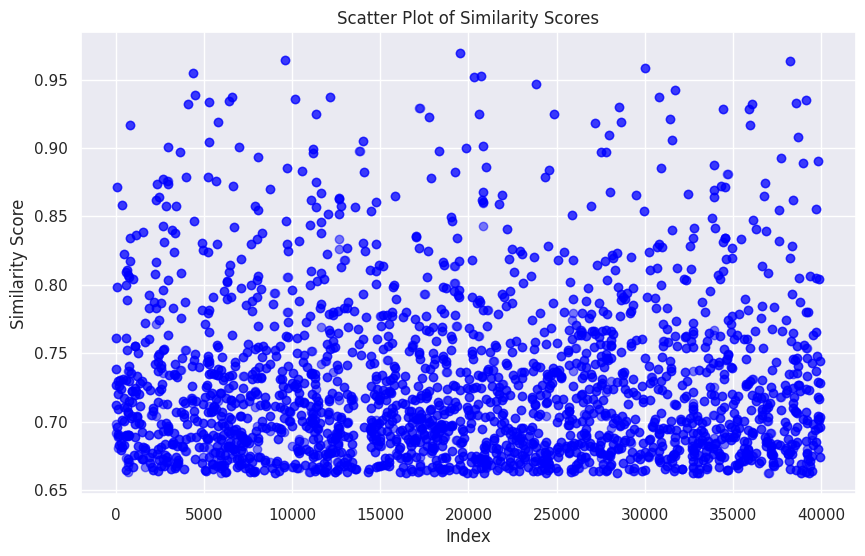

In [75]:
import matplotlib.pyplot as plt

# Assuming 'merged_200' is your DataFrame and it's already loaded with data
# Check if 'merged_200' is correctly defined and contains 'Similarity Score'
if 'Similarity Score' in merged_200.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df_probe.index[:9000], merged_df_probe['Similarity Score'][:9000], color='blue', alpha=0.5)
    plt.title('Scatter Plot of Similarity Scores')
    plt.xlabel('Index')
    plt.ylabel('Similarity Score')
    plt.grid(True)
    plt.show()
else:
    print("The DataFrame does not contain a 'Similarity Score' column.")


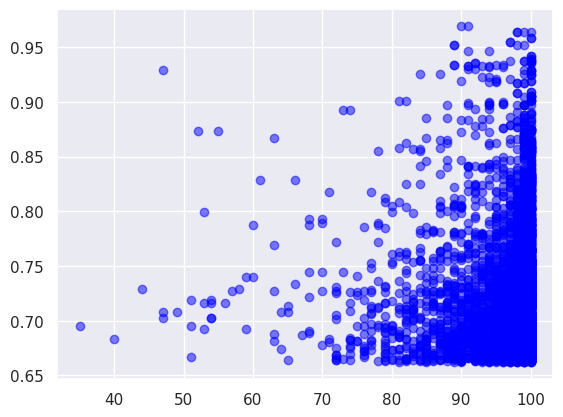

In [72]:
merged_df_probe = merged_df_probe.sort_values(by='Similarity Score', ascending=False)[:8000]
plt.scatter(merged_df_probe['HeadPoseYaw.scalar'], merged_df_probe['Similarity Score'], color='blue', alpha=0.5)


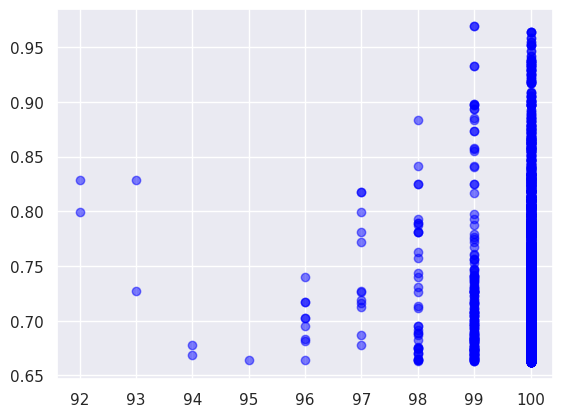

In [73]:
plt.scatter(merged_df_probe['HeadPoseRoll.scalar'], merged_df_probe['Similarity Score'], color='blue', alpha=0.5)


In [ ]:
# Plot the similarity scores

In [37]:
correlation_matrix_top = pd.merge(top_20_pairs, OFIQ_a, left_on='Probe Image', right_on='image_name').corr()
print(correlation_matrix_top['Similarity Score'].sort_values)


<bound method Series.sort_values of Similarity Score                      1.000000
UnifiedQualityScore                  -0.387575
BackgroundUniformity                  0.257343
IlluminationUniformity               -0.217424
LuminanceMean                         0.334908
LuminanceVariance                     0.076367
UnderExposurePrevention               0.097896
OverExposurePrevention                0.010126
DynamicRange                         -0.101810
Sharpness                             0.082425
CompressionArtifacts                  0.358812
NaturalColour                        -0.010987
SingleFacePresent                          NaN
EyesOpen                              0.317246
MouthClosed                           0.251121
EyesVisible                                NaN
MouthOcclusionPrevention                   NaN
FaceOcclusionPrevention               0.114005
InterEyeDistance                      0.019346
HeadSize                              0.123038
LeftwardCropOfTheFaceIma

In [29]:
correlation_matrix_bottom = pd.merge(bottom_20_pairs, OFIQ_a, left_on='Probe Image', right_on='image_name').corr()
print(correlation_matrix_bottom['Similarity Score'])

Similarity Score                      1.000000
UnifiedQualityScore                   0.009022
BackgroundUniformity                 -0.289067
IlluminationUniformity                0.198027
LuminanceMean                         0.150022
LuminanceVariance                     0.210675
UnderExposurePrevention               0.040742
OverExposurePrevention                     NaN
DynamicRange                          0.078763
Sharpness                            -0.099956
CompressionArtifacts                  0.518990
NaturalColour                         0.087271
SingleFacePresent                     0.047820
EyesOpen                             -0.046436
MouthClosed                          -0.137766
EyesVisible                          -0.013664
MouthOcclusionPrevention             -0.419749
FaceOcclusionPrevention              -0.102334
InterEyeDistance                     -0.171042
HeadSize                             -0.046741
LeftwardCropOfTheFaceImage           -0.234353
RightwardCrop

In [31]:
import pandas as pd

# Assuming top_20_pairs, bottom_20_pairs, and OFIQ_a have been properly defined and loaded
correlation_matrix_top = pd.merge(top_20_pairs, OFIQ_a, left_on='Probe Image', right_on='image_name').corr()
correlation_top_similarity = correlation_matrix_top['Similarity Score']
print("Top 20 Correlation with Similarity Score:\n", correlation_top_similarity)

correlation_matrix_bottom = pd.merge(bottom_20_pairs, OFIQ_a, left_on='Probe Image', right_on='image_name').corr()
correlation_bottom_similarity = correlation_matrix_bottom['Similarity Score']
print("Bottom 20 Correlation with Similarity Score:\n", correlation_bottom_similarity)


Top 20 Correlation with Similarity Score:
 Similarity Score                      1.000000
UnifiedQualityScore                  -0.387575
BackgroundUniformity                  0.257343
IlluminationUniformity               -0.217424
LuminanceMean                         0.334908
LuminanceVariance                     0.076367
UnderExposurePrevention               0.097896
OverExposurePrevention                0.010126
DynamicRange                         -0.101810
Sharpness                             0.082425
CompressionArtifacts                  0.358812
NaturalColour                        -0.010987
SingleFacePresent                          NaN
EyesOpen                              0.317246
MouthClosed                           0.251121
EyesVisible                                NaN
MouthOcclusionPrevention                   NaN
FaceOcclusionPrevention               0.114005
InterEyeDistance                      0.019346
HeadSize                              0.123038
LeftwardCropOfThe

In [32]:
# Finding the highest positive correlation from the top 20 pairs
highest_top = correlation_top_similarity.drop('Similarity Score', errors='ignore').idxmax()  # Ignore self-correlation
highest_top_value = correlation_top_similarity[highest_top]

# Finding the highest positive correlation from the bottom 20 pairs
highest_bottom = correlation_bottom_similarity.drop('Similarity Score', errors='ignore').idxmax()  # Ignore self-correlation
highest_bottom_value = correlation_bottom_similarity[highest_bottom]

print(f"Highest positive correlation in top 20 is {highest_top} with a value of {highest_top_value}")
print(f"Highest positive correlation in bottom 20 is {highest_bottom} with a value of {highest_bottom_value}")

# Determine which is higher
if highest_top_value > highest_bottom_value:
    print(f"The component with the highest positive correlation overall is {highest_top} from the top 20 pairs.")
else:
    print(f"The component with the highest positive correlation overall is {highest_bottom} from the bottom 20 pairs.")


Highest positive correlation in top 20 is HeadPoseYaw with a value of 0.41169148107578796
Highest positive correlation in bottom 20 is HeadPoseRoll.scalar with a value of 0.5779016219477113
The component with the highest positive correlation overall is HeadPoseRoll.scalar from the bottom 20 pairs.


In [36]:
# Finding the highest positive correlation from the top 20 pairs
lowest_top = correlation_top_similarity.drop('Similarity Score', errors='ignore').idxmin()  # Ignore self-correlation
lowest_top_value = correlation_top_similarity[lowest_top]

# Finding the highest positive correlation from the bottom 20 pairs
lowest_bottom = correlation_bottom_similarity.drop('Similarity Score', errors='ignore').idxmin()  # Ignore self-correlation
lowest_bottom_value = correlation_bottom_similarity[lowest_bottom]

print(f"Highest positive correlation in top 20 is {lowest_top} with a value of {lowest_top_value}")
print(f"Highest positive correlation in bottom 20 is {lowest_bottom} with a value of {lowest_bottom_value}")

# Determine which is higher
if lowest_top_value > lowest_bottom_value:
    print(f"The component with the highest positive correlation overall is {lowest_top} from the top 20 pairs.")
else:
    print(f"The component with the highest positive correlation overall is {lowest_bottom} from the bottom 20 pairs.")


Highest positive correlation in top 20 is HeadPoseRoll.scalar with a value of -0.5405420777359942
Highest positive correlation in bottom 20 is HeadPoseRoll with a value of -0.6144984579699463
The component with the highest positive correlation overall is HeadPoseRoll.scalar from the top 20 pairs.


<Figure size 2000x1000 with 0 Axes>

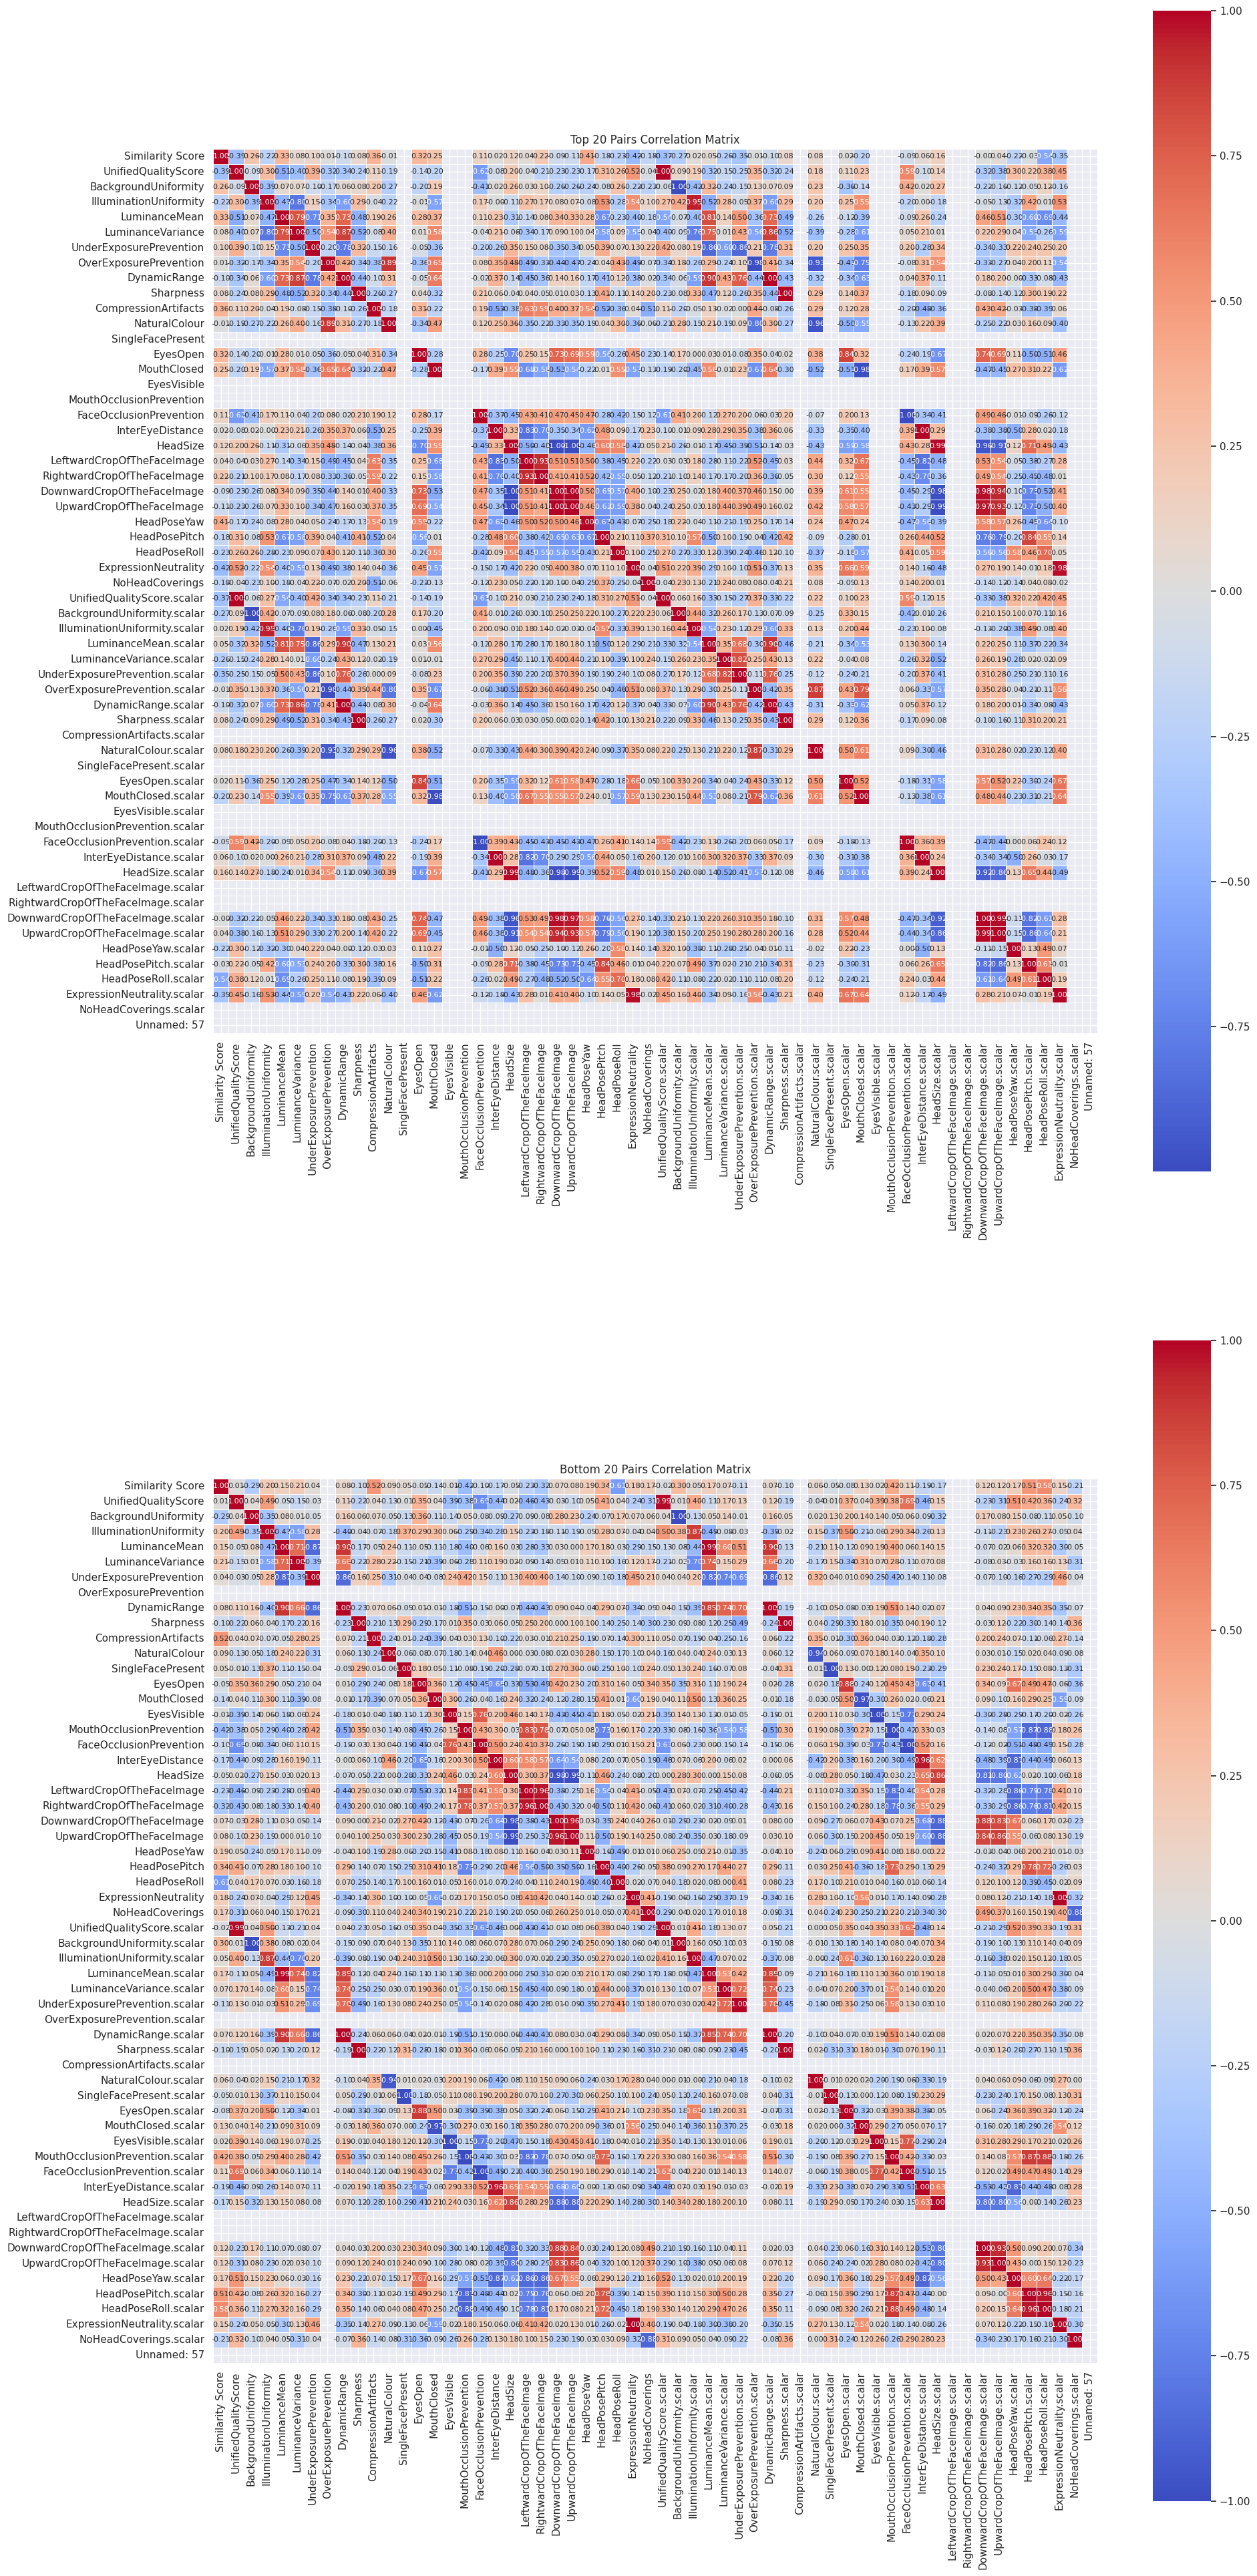

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_matrix_top and correlation_matrix_bottom are already defined

# Create a larger figure to better accommodate the data
plt.figure(figsize=(20, 10))

# Set up a subplot grid that wraps two vertical subplots for better comparison
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 40))

# Generate a heatmap for the top 20 pairs correlation matrix
sns.heatmap(correlation_matrix_top, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            ax=axes[0], annot_kws={"size": 8}, square=True, linewidths=.5)
axes[0].set_title('Top 20 Pairs Correlation Matrix')
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=0)

# Generate a heatmap for the bottom 20 pairs correlation matrix
sns.heatmap(correlation_matrix_bottom, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            ax=axes[1], annot_kws={"size": 8}, square=True, linewidths=.5)
axes[1].set_title('Bottom 20 Pairs Correlation Matrix')
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

# Adjust layout to make room for label rotation
plt.tight_layout()

# Show the plot
plt.show()
